In [619]:
# 1.
from trackml import dataset, randomize, score, weights

import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession

In [620]:
# 2. prep dataframe

def file_url(event_id, category, train_or_test="train"):
    if category.startswith("blacklist"):
        folder = "blacklist"
    else:
        folder = train_or_test
    return '/home/ec2-user/SageMaker/efs/dataset/{0}/event{1:09d}-{2}.csv'.format(folder, event_id, category)

# load truth, blacklist_particles and blacklist_hits files for event 1000
truth = pd.read_csv(file_url(1000, 'truth'))
blacklist_particles = pd.read_csv(file_url(1000, 'blacklist_particles'))
blacklist_hits = pd.read_csv(file_url(1000, 'blacklist_hits'))

# filter out track 0 (garbage track), tracks with three or fewer hits, and  rows with blacklisted hits and particles.
not_particle_zero = truth.particle_id != 0 
not_blacklist_particle = ~truth.particle_id.isin(blacklist_particles.particle_id)
not_blacklist_hit = ~truth.hit_id.isin(blacklist_hits.hit_id)

particle_num_hits = truth.groupby('particle_id')['particle_id'].transform('count')
not_short_track = particle_num_hits > 3

print("total rows:\t\t", truth.shape[0])
truth = truth[not_particle_zero & not_blacklist_particle & not_blacklist_hit & not_short_track]
print("rows after filtering:\t", truth.shape[0])

# columns for number of hits registered by a particle, transverse momentum pT, total weight of particle,
# and component of weight derived from particle, which is the hit weight normalized by particle.
truth.loc[:, 'particle_num_hits'] = truth.groupby('particle_id')['particle_id'].transform('count')
truth.loc[:, 'pt'] = np.sqrt(truth.tpx**2 + truth.tpy**2)
truth.loc[:, 'particle_weight'] = truth.groupby('particle_id')['weight'].transform('sum')
truth.loc[:, 'weight_order'] = truth.weight/truth.particle_weight

# array of particle ids
particle_ids = truth.particle_id.unique()

# reset index to [0, 1, 2, ...]
truth.reset_index(drop=True, inplace=True)

truth.head()

total rows:		 120939
rows after filtering:	 101023


,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight,particle_num_hits,pt,particle_weight,weight_order
0,2,22525763437723648,-55.3385,0.630805,-1502.5,-0.570605,0.028390,-15.49220,0.000010,10,0.571311,0.000090,0.110204
1,4,297237712845406208,-96.1229,-8.230360,-1502.5,-0.225235,-0.050968,-3.70232,0.000008,11,0.230930,0.000081,0.101010
2,5,418835796137607168,-62.6594,-9.375040,-1502.5,-0.281806,-0.023487,-6.57318,0.000009,10,0.282783,0.000081,0.110204
3,6,108087696726949888,-57.0856,-8.189710,-1502.5,-0.401129,-0.035276,-10.46690,0.000008,11,0.402677,0.000081,0.101010
4,7,968286151951515648,-73.8608,-2.575860,-1502.5,-0.442662,-0.036969,-9.13010,0.000007,13,0.444203,0.000081,0.086539


In [618]:
help(plt.subplots)

Help on function subplots in module matplotlib.pyplot:

subplots(nrows=1, ncols=1, sharex=False, sharey=False, squeeze=True, subplot_kw=None, gridspec_kw=None, **fig_kw)
    Create a figure and a set of subplots
    
    This utility wrapper makes it convenient to create common layouts of
    subplots, including the enclosing figure object, in a single call.
    
    Parameters
    ----------
    nrows, ncols : int, optional, default: 1
        Number of rows/columns of the subplot grid.
    
    sharex, sharey : bool or {'none', 'all', 'row', 'col'}, default: False
        Controls sharing of properties among x (`sharex`) or y (`sharey`)
        axes:
    
            - True or 'all': x- or y-axis will be shared among all
              subplots.
            - False or 'none': each subplot x- or y-axis will be
              independent.
            - 'row': each subplot row will share an x- or y-axis.
            - 'col': each subplot column will share an x- or y-axis.
    
        Whe

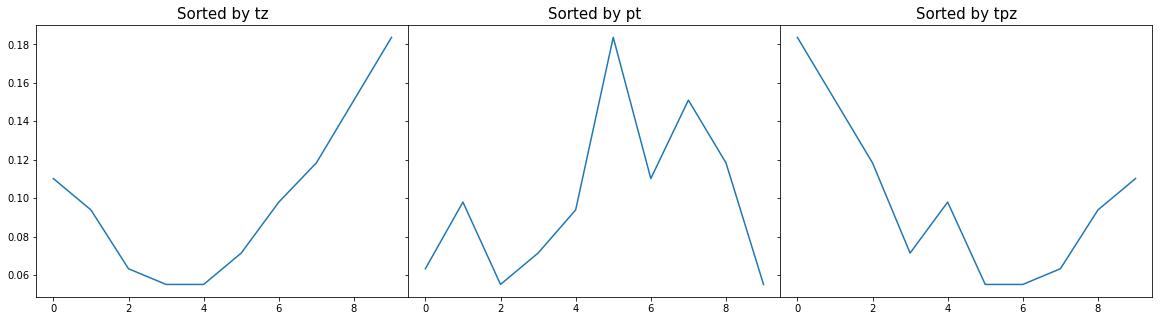

In [694]:
# 3. plot weight_pt when sorting by a variety of candidate features.
# Choose tz as the best.
pid = particle_ids[0]
particle = truth[truth.particle_id == pid].reset_index(drop=True)

f, axarr = plt.subplots(ncols=3, sharey=True)
f.set_figwidth(20)
f.set_figheight(5)
f.subplots_adjust(wspace=0)
                        
axarr[0].plot(particle.index, particle.sort_values(by='tz').weight_order)
axarr[0].set_title('Sorted by tz', fontsize=15)

axarr[1].plot(particle.index, particle.sort_values(by='pt').weight_order)
axarr[1].set_title('Sorted by pt', fontsize=15)
                        
axarr[2].plot(particle.index, particle.sort_values(by='tpz').weight_order)
axarr[2].set_title('Sorted by tpz', fontsize=15)

plt.show()

In [526]:
# 4. create tracks dataframe
particles = truth.loc[:, [
    'hit_id',
    'particle_id',
    'weight_order',
    'tz', 
    'tpz',
]]

########### create z_order_dim.
# z_order_dim is simply tz if tz is ascending in order of hits, and is -tz otherwise.
# The prodecure for establishing z_order_dim takes advantage of the fact that weight_order
# is larger for the first hit than for the last hit.

tz_idxmin = particles.groupby('particle_id')['tz'].transform('idxmin')
tz_idxmax = particles.groupby('particle_id')['tz'].transform('idxmax')

weight_order_tzmin = particles.loc[tz_idxmin, 'weight_order'].reset_index(drop=True)
weight_order_tzmax = particles.loc[tz_idxmax, 'weight_order'].reset_index(drop=True)

z_direction = np.sign(weight_order_tzmin - weight_order_tzmax)

particles.loc[:, 'z_order_dim'] = z_direction*particles.tz
particles.drop('tz', axis=1, inplace=True)

###########

# create hit_order column
particles.loc[:, 'hit_order'] = particles.groupby('particle_id').z_order_dim.rank(method='first', ascending=True).astype(int)
particles.drop('z_order_dim', axis=1, inplace=True)

particles.set_index(['particle_id', 'hit_order'], inplace=True)
particles.sort_index(inplace=True)

tpz = particles.tpz
particles.drop('tpz', axis=1, inplace=True)

particles.head()

hit_id  weight_order
particle_id      hit_order                      
4503668346847232 1           20880      0.225806
                 2           29323      0.174194
                 3           35621      0.129032
                 4           42238      0.093548
                 5           73763      0.067742

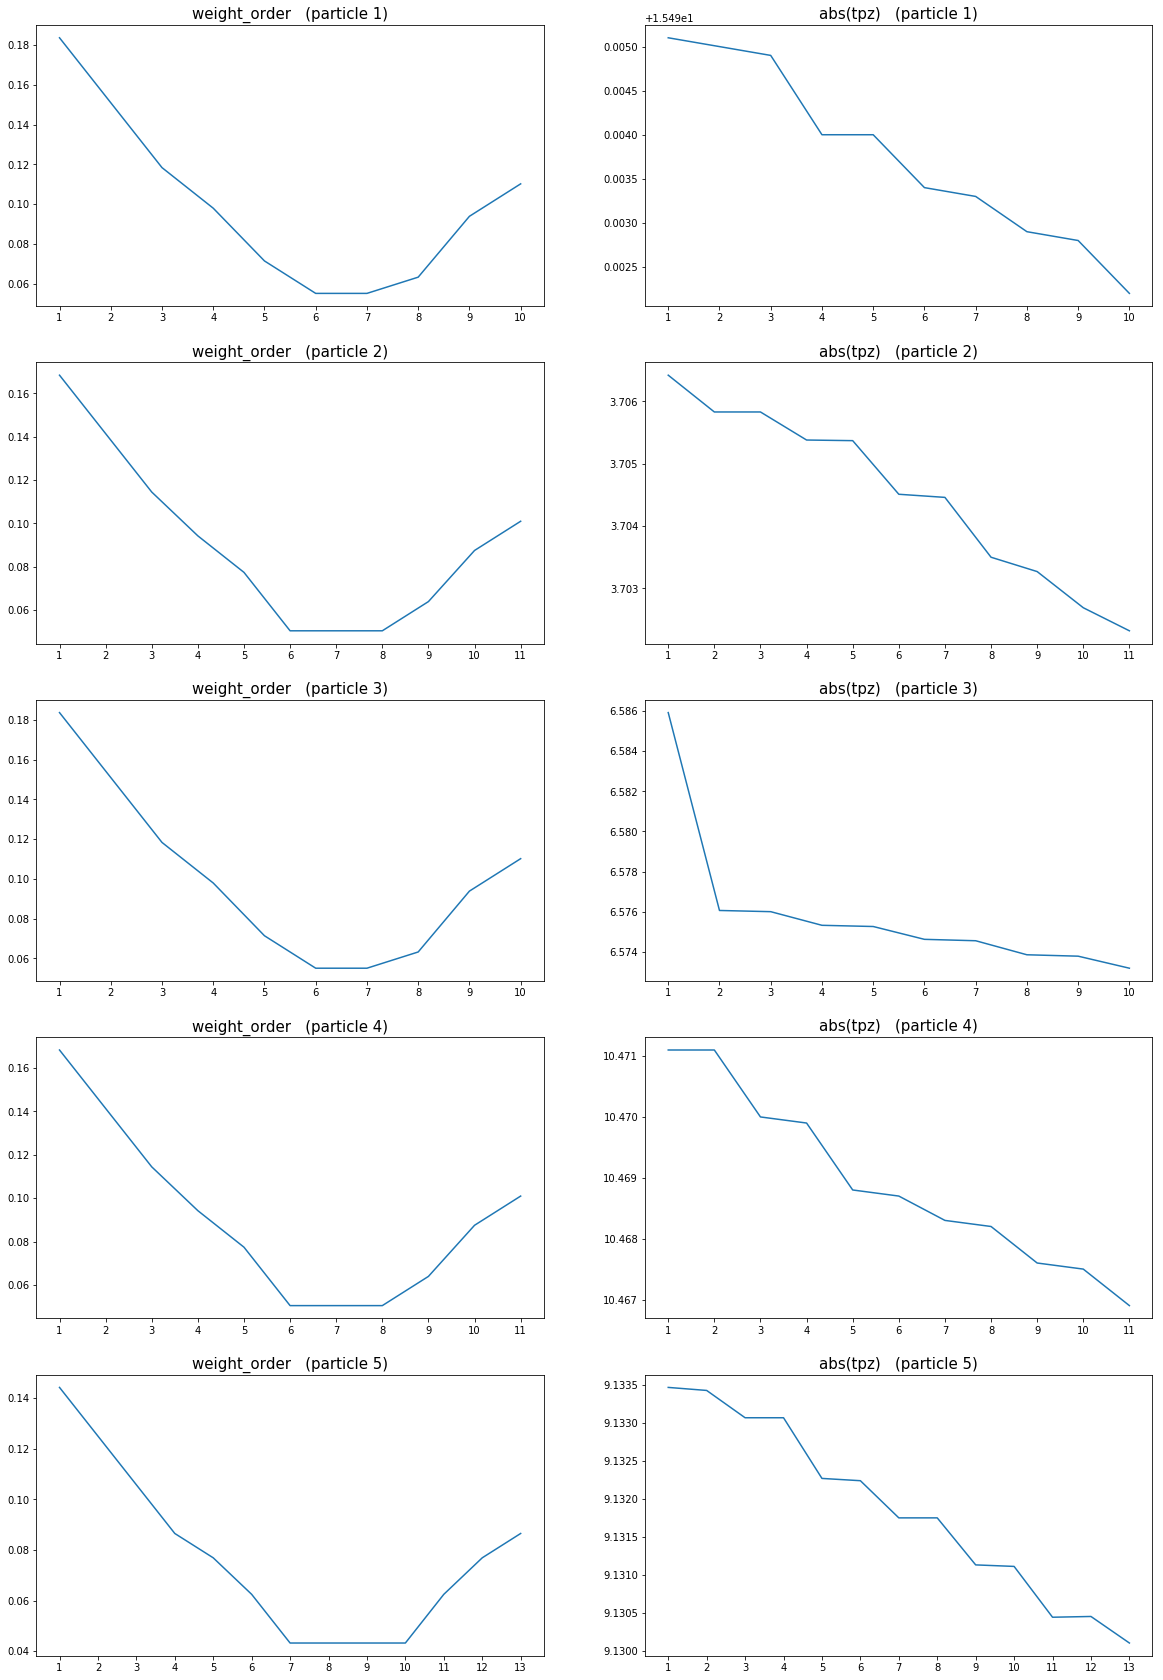

In [702]:
# 5. plot abs(tpz) against hit_order for first 5 tracks. That abs(tpz) is decreasing supports the case that we have the correct order.
# Note: apparently it didn't work to sort by tpz because this column is monotonic but not not strictly monotonic.
f, axarr = plt.subplots(nrows=5, ncols=2)
f.set_figwidth(20)
f.set_figheight(30)
# f.subplots_adjust(wspace=0)

for i, pid in enumerate(particle_ids[:5]):
    hit_order = particles.loc[pid].index

    axarr[i][0].plot(hit_order, particles.loc[pid].weight_order)
    axarr[i][0].set_title('weight_order   (particle {0})'.format(i+1), fontsize=15)
    axarr[i][0].set_xticks(hit_order)

    axarr[i][1].plot(hit_order, tpz.loc[pid].abs())
    axarr[i][1].set_title('abs(tpz)   (particle {0})'.format(i+1), fontsize=15)
    axarr[i][1].set_xticks(hit_order)
    
plt.show()

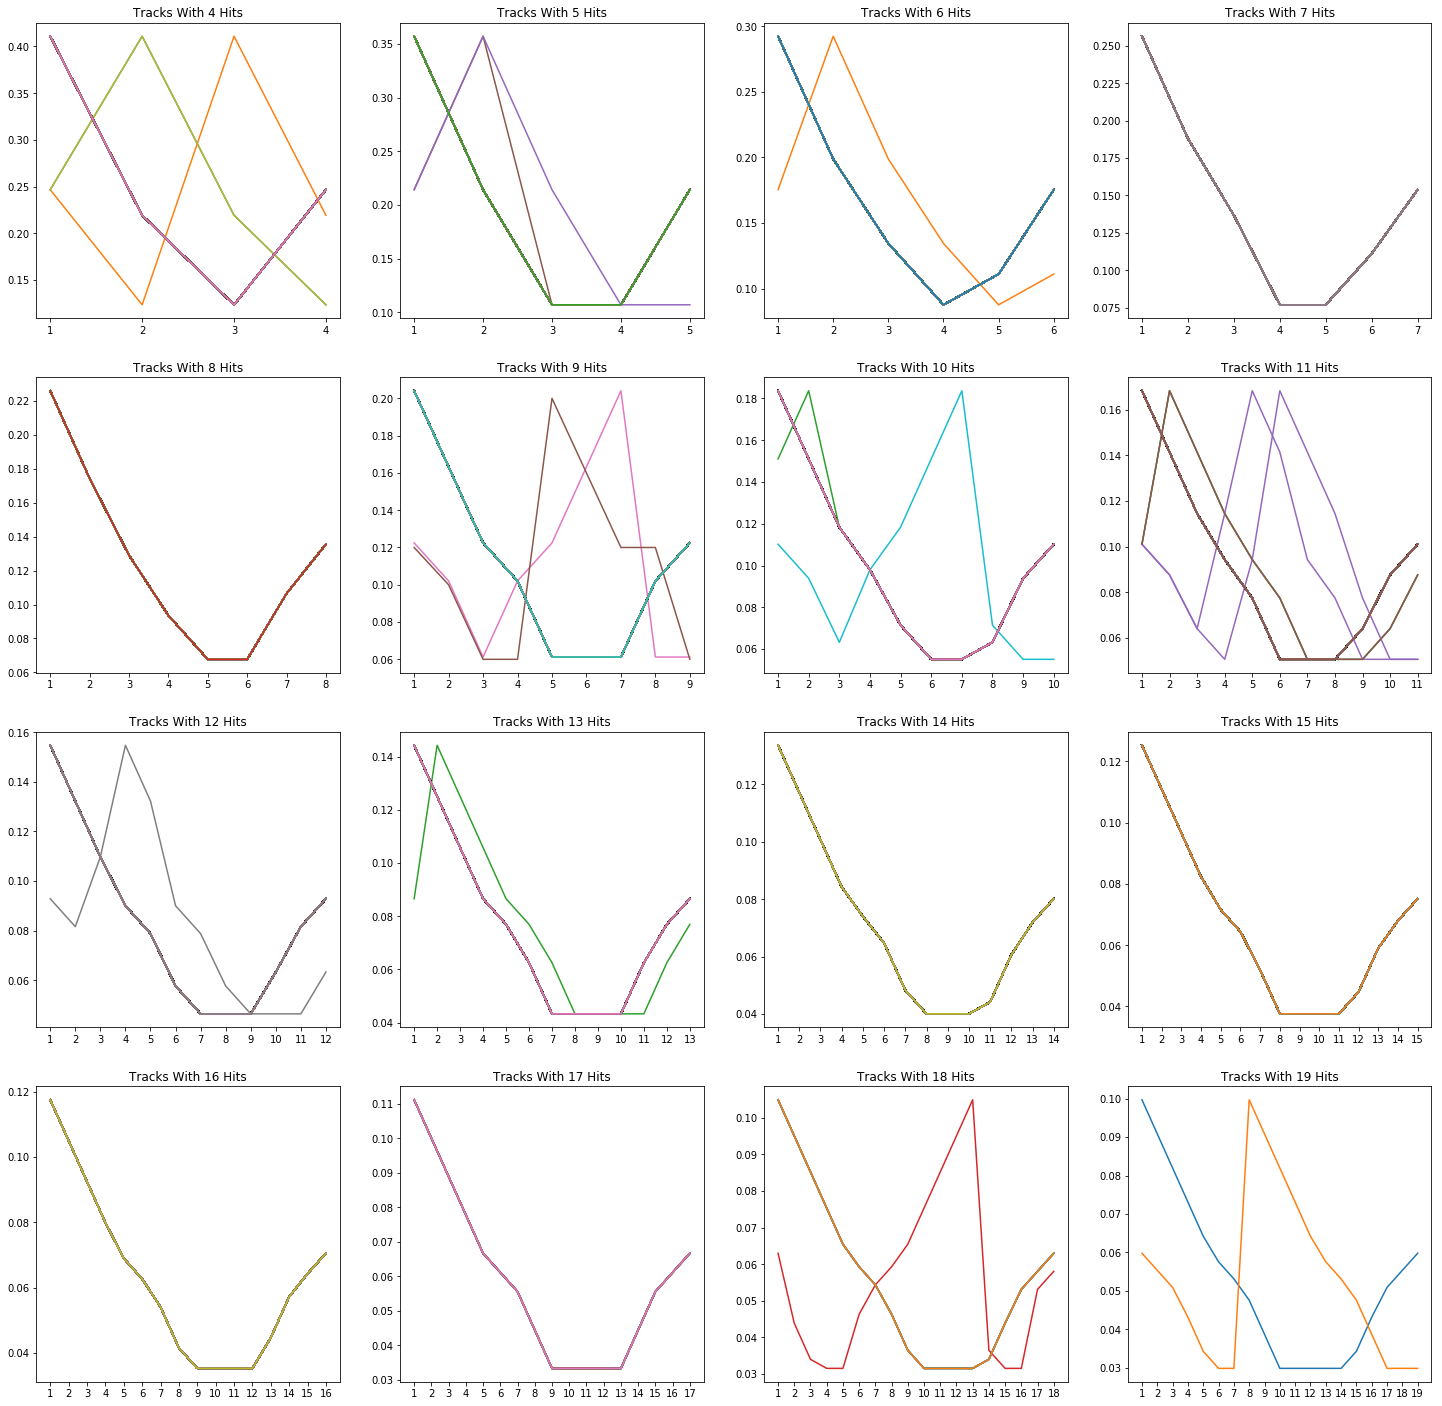

In [700]:
# 6. plot weight_order against tz for all tracks, grouped by number of hits

f, axarr = plt.subplots(nrows=4, ncols=4)

axdict = {i: axarr[(i-4) // 4][i % 4] for i in range(4, 20)}

f.set_figheight(25)
f.set_figwidth(25)

for i in axdict:
        axdict[i].set_title('Tracks With {0} Hits'.format(i))
        axdict[i].set_xticks(np.arange(1, i+1))

track_lengths = particles.groupby('particle_id').size()
for pid in particle_ids:
    particle = particles.loc[pid]
    axdict[track_lengths[pid]].plot(particle.weight_order)

plt.show()

In [552]:
# 7. create series weight_order.
particles.loc[:, 'track_length'] = particles.groupby(level='particle_id').hit_id.transform('count')

true_weight_order = particles.groupby(['track_length', 'hit_order']).weight_order.median()
particles.drop('track_length', axis=1, inplace=True)

true_weight_order.head()

track_length  hit_order
4             1            0.410959
              2            0.219178
              3            0.123288
              4            0.246575
5             1            0.357143
Name: weight_order, dtype: float64

total particles with hits out of order: 20
percent particles with hits in order: 99.784297


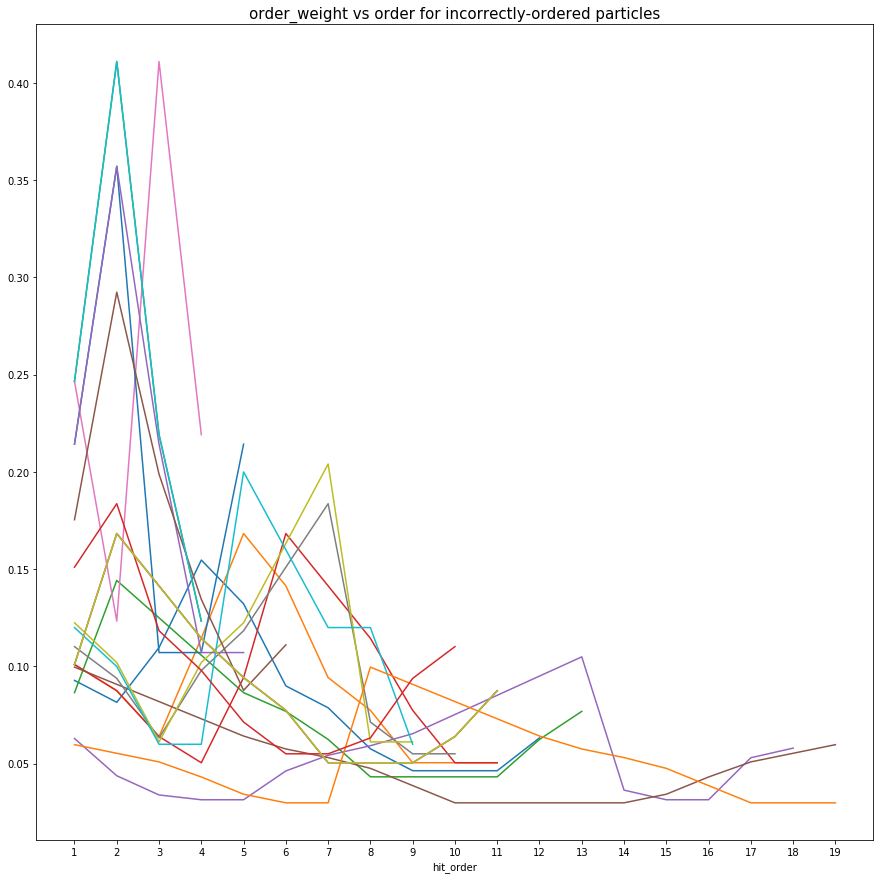

In [708]:
# 8. count particles whose hits are out of order.
def correct_order(particle):
    return np.all(
        np.isclose(
            particle.weight_order.values, true_weight_order.loc[len(particle)].values,
            atol=1e-06
        )
    )

particles_correct_order = particles.groupby(level='particle_id').apply(correct_order)
bad_particles = particles_correct_order[~particles_correct_order.values].index.values
for pid in bad_particles:
    particles.loc[pid].weight_order.plot(figsize=(15, 15))

print('total particles with hits out of order:', len(bad_particles))
print('percent particles with hits in order: {:2f}'.format(100*(1. - len(bad_particles)/len(particle_ids))))
plt.xticks(np.arange(1, 20))
plt.title('order_weight vs order for incorrectly-ordered particles', fontsize=15)
plt.show()

In [598]:
# 9. remove bad particles, reset index and reorder columns.
mask = particles_correct_order.loc[particles.index.get_level_values('particle_id')].values
valid_particles = particles[mask].loc[:, 'hit_id'].reset_index()[['particle_id', 'hit_id', 'hit_order']]

valid_particles.head()

,particle_id,hit_id,hit_order
0,4503668346847232,20880,1
1,4503668346847232,29323,2
2,4503668346847232,35621,3
3,4503668346847232,42238,4
4,4503668346847232,73763,5


In [602]:
# 10. write to csv.
valid_particles.to_csv('/home/ec2-user/SageMaker/efs/particles-in-order/event000001000-hit_orders.csv', index=False)